In [1]:
import os
import sys
import subprocess
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, endf_tools
import numpy as np
import openmc
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [2]:
VERSION = "v3"
TEMPERATURE = 900 # K
N_ITERATIONS = 500

RUN_NAME = "R11" 

MT_to_run_number = {
    2: 1,
    16: 1001,
    22: 2001,
    28: 3001,
    102: 4001,
    103: 5001,
    104: 6001,
    105: 7001,
    107: 8001,
    4: 9001,
}

# Load the .pkl file from the run to get TMC results
tmc_df = pd.read_pickle(f"../runs/{RUN_NAME}/plotting/tmc_df.pkl")

for MT_INT in [2, 4, 16, 22, 28, 102, 103, 104, 105, 107]:
# for MT_INT in [2, 16, 22, 28, 102, 103, 104, 105, 107]:
    # print("WARING_ CHANGE MT_INT TO 2, 4, 16, 22, 28, 102, 103, 104, 105, 107")
# for MT_INT in [2, 16]:
    print(f"Handling MT{MT_INT}")
    plt.close('all')

    MT_STRING = f"{MT_INT:03d}"

    res_folder = f"results/MT{MT_INT}"
    os.system(f"rm -rf {res_folder}")
    os.makedirs(res_folder, exist_ok=True)

    df = pd.DataFrame(columns=["energy", "xs"])

    sampled_h5_files_path = f"/home/fne23_stjarnholm/nuclear_data/sandy_samples_v3-MT{MT_INT}"

    # x_logspace = np.logspace(np.log10(1e-2), np.log10(1e7), 1000)
    x_logspace = np.logspace(-2, 7, 1001) #1000 bins between 1e-2 eV and 1e7 eV

    for i in tqdm(range(N_ITERATIONS)):
        h5_filename = f"{sampled_h5_files_path}/F19-{i+1}.h5"

        h5file = h5py.File(h5_filename, 'r')
        energy_group = h5file[f'F19/energy/{TEMPERATURE}K']
        reactions_group = h5file[f'F19/reactions']

        xs_group = reactions_group[f'reaction_{MT_STRING}/{TEMPERATURE}K/xs']

        # Extract the cross section and energy data
        xs = xs_group[:]
        XS_LEN = len(xs)
        if len(xs) != len(energy_group[:]):
            energy = energy_group[-len(xs):]
        else:
            energy = energy_group[:]
    
        # Interpolate the cross section to the desired energy grid
        xs = np.interp(x_logspace, energy, xs, left=0, right=0)
        energy = x_logspace

        df = pd.concat([df, pd.DataFrame({"energy": energy, "xs": xs})], ignore_index=True)

    # Calculate the means and standard deviations
    df_mean = df.groupby("energy").mean().reset_index()
    df_std = df.groupby("energy").std().reset_index()

    df_flux = pd.DataFrame(columns=["energy", "group_flux", "spectrum", "fast_reactor", "MT"])

    for FAST_REACTOR in [False, True]:
        neutron_temperatue_label = "Thermal" if not FAST_REACTOR else "Epithermal"

        run_number = MT_to_run_number[MT_INT]
        if FAST_REACTOR:
            run_number += 500 # MT2 thermal, is 1, MT2 fast is 501, etc...

        results_dir = f"../runs/{RUN_NAME}/results/RUNDATA_{RUN_NAME}_{run_number}"

        # Load the run_settings.json file and make sure MT and FAST_REACTOR are correct
        run_settings = run_tools.load_run_settings_json(results_dir)
        assert run_settings["MT"] == MT_INT
        assert run_settings["fast_reactor"] == FAST_REACTOR

        file = f"{results_dir}/statepoint.350.h5"
        sp = openmc.StatePoint(file)

        tallydf=sp.tallies[1].get_pandas_dataframe()
        tallydfflux=tallydf[tallydf['score']=='flux']
        energy=(tallydfflux['energy low [eV]']+tallydfflux['energy high [eV]'])/2

        group_flux = tallydfflux['mean']

        plt.figure(1)
        plt.loglog(energy, group_flux, label=neutron_temperatue_label)

        deltaE=(tallydfflux['energy high [eV]']-tallydfflux['energy low [eV]'])
        spectrum = tallydfflux['mean']/deltaE
        
        plt.figure(2)
        plt.loglog(energy, spectrum,lw=2, label=neutron_temperatue_label)

        df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)

    plt.figure(1)
    plt.xlabel('$E_n$ [eV]')
    plt.ylabel('Group flux per source particle')
    plt.xlim(1e-2, 1e7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{res_folder}/group_flux_per_source_particle.pdf")

    plt.figure(2)
    plt.xlabel('$E_n$ [eV]')
    plt.ylabel('Spectrum per source particle (1/eV)')
    plt.xlim(1e-2, 1e7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{res_folder}/spectrum_per_source_particle.pdf")

    # Fold the flux with the std of the sampled data in df_std
    for FAST_REACTOR in [False, True]:
        NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
        print(f"Folding {NEUTRON_TEMP}, MT{MT_INT}")
        df_this_temp = df_flux[df_flux["fast_reactor"] == FAST_REACTOR]

        # Intepolate the flux to the energy grid of the sampled data
        flux = np.interp(df_std["energy"], df_this_temp["energy"], df_this_temp["spectrum"], left=0, right=0)


        # NORMALIZE WITH MEAN
        # Find the indecies where df_mean is non-zero
        non_zero_indecies = np.where(df_mean["xs"] != 0)[0]

        # Fold the flux with the std of the sampled data in df_std, normalized with the mean of the sampled data in df_mean
        # Only fold where the mean is non-zero
        # Make rest of the values 0
        df_std["xs_fw_normalized"] = np.zeros(len(df_std))
        df_std["xs_fw_normalized"].iloc[non_zero_indecies] = df_std["xs"].iloc[non_zero_indecies] * flux[non_zero_indecies] / df_mean["xs"].iloc[non_zero_indecies]


        # DO NOT NORMALIZE WITH MEAN
        # Fold the flux with the std of the sampled data in df_std
        df_std["xs_fw_not_normalized"] = df_std["xs"] * flux

        

        # Integrate the folded cross section
        xs_fw_integrated_normalized = np.trapz(df_std["xs_fw_normalized"], df_std["energy"])
        xs_fw_integrated_not_normalized = np.trapz(df_std["xs_fw_not_normalized"], df_std["energy"])
        print(f"{MT_INT}, {xs_fw_integrated_normalized}")
        print(f"{MT_INT}, {xs_fw_integrated_not_normalized}")
        print(f"{MT_INT}, {np.sum(df_std['xs_fw_normalized'])}")
        print(f"{MT_INT}, {np.sum(df_std['xs_fw_not_normalized'])}")

        # Add the result to the corresponding TMC result
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "sum_xs_fw_normalized"] = np.sum(df_std["xs_fw_normalized"])
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "sum_xs_fw_not_normalized"] = np.sum(df_std["xs_fw_not_normalized"])
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "xs_fw_integrated_normalized"] = xs_fw_integrated_normalized
        tmc_df.loc[(tmc_df["MT"] == MT_INT) & (tmc_df["fast_reactor"] == FAST_REACTOR), "xs_fw_integrated_not_normalized"] = xs_fw_integrated_not_normalized
        

Handling MT2


100%|██████████| 500/500 [00:05<00:00, 93.81it/s] 
/tmp/ipykernel_13796/3147077450.py:104: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_flux = pd.concat([df_flux, pd.DataFrame({"energy": energy, "group_flux": group_flux, "spectrum": spectrum, "fast_reactor": FAST_REACTOR, "MT": MT_INT})], ignore_index=True)


Folding THERMAL, MT2
2, 1.21433764359618
2, 4.212915521911125
2, 110.54905237827357
2, 422.3580896737228
Folding EPITHERMAL, MT2
2, 0.3407349722385125
2, 1.275536634200353
2, 4.985939362031659
2, 18.91188045227122
Handling MT4


  0%|          | 0/500 [00:00<?, ?it/s]


KeyError: 'Unable to open object (component not found)'

In [5]:
tmc_df.head()

,sigma_obs,sigma2_obs,sigma_stat_mean,sigma2_stat_mean,sigma_ND,sigma2_ND,k_eff_mean,R_obs,R_stat_mean,R_ND,u_k,u_rho,N_ITERATIONS,fast_reactor,MT,MT_label,sum_xs_fw_normalized,sum_xs_fw_not_normalized,xs_fw_integrated_normalized,xs_fw_integrated_not_normalized
0,0.000620,3.843546e-07,0.000315,9.938319e-08,0.000534,2.849714e-07,1.366908,0.000454,0.000231,0.000391,1.3669+/-0.0005,0.26842+/-0.00029,500,False,2,"(n,elastic)",2.684598,9.501082e+00,47174.000790,90986.631605
1,0.000332,1.101153e-07,0.000315,9.948214e-08,0.000103,1.063319e-08,1.366936,0.000243,0.000231,0.000075,1.36694+/-0.00010,0.26844+/-0.00006,500,False,16,"(n,2n)",0.000000,0.000000e+00,0.000000,0.000000
2,0.000366,1.343042e-07,0.000315,9.897826e-08,0.000188,3.532597e-08,1.366931,0.000268,0.000230,0.000137,1.36693+/-0.00019,0.26843+/-0.00010,500,False,22,"(n,na)",0.134676,4.872470e-03,15398.736246,768.587073
3,0.000365,1.331519e-07,0.000315,9.896287e-08,0.000185,3.418907e-08,1.366967,0.000267,0.000230,0.000135,1.36697+/-0.00018,0.26845+/-0.00010,500,False,28,"(n,np)",0.004424,9.714810e-07,825.768559,0.194595
4,0.000710,5.044857e-07,0.000315,9.920872e-08,0.000637,4.052770e-07,1.366929,0.000520,0.000230,0.000466,1.3669+/-0.0006,0.26843+/-0.00034,500,False,102,"(n,$\gamma$)",14.053911,2.115395e-02,196624.111494,23.297534


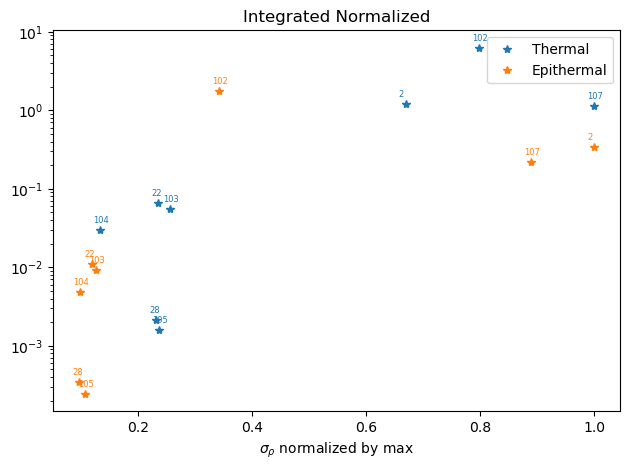

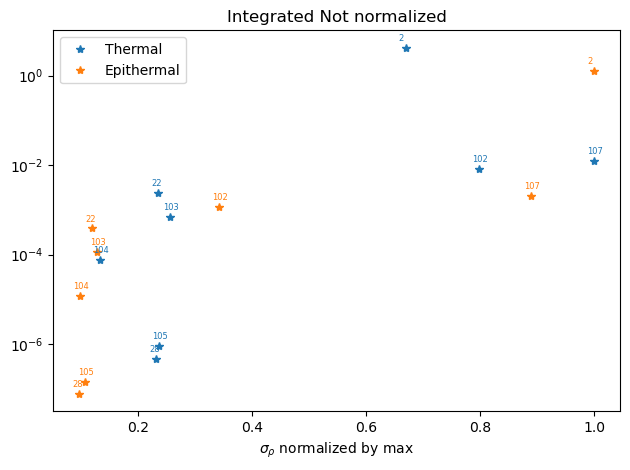

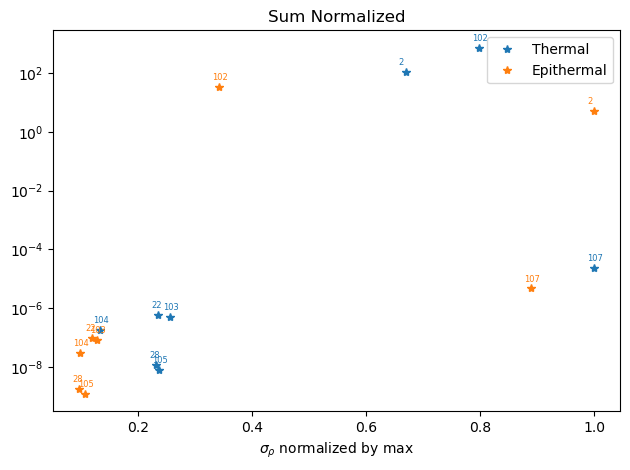

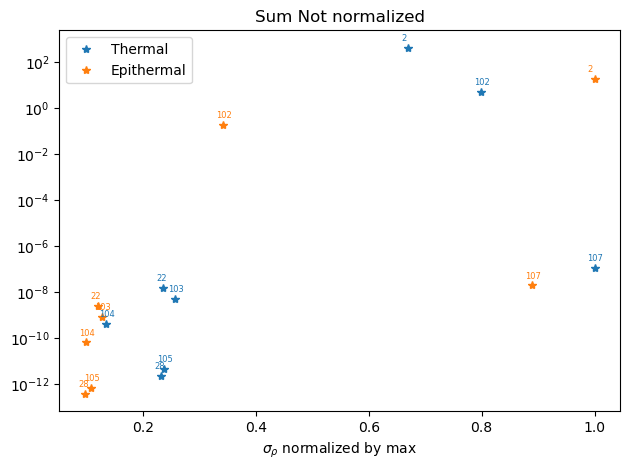

In [25]:
from uncertainties import unumpy

plt.close("all")
for FAST_REACTOR in [False, True]:
    neutron_temperatue_label = "Thermal" if not FAST_REACTOR else "Epithermal"
    df_thistemp = tmc_df[tmc_df["fast_reactor"] == FAST_REACTOR]

    x_axis = unumpy.std_devs(df_thistemp["u_rho"]) * 1e5
    x_axis = x_axis / np.max(x_axis) # Normalize to 1

    
    plt.figure(1)
    plt.semilogy(x_axis, df_thistemp["xs_fw_integrated_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Integrated Normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()
    
    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["xs_fw_integrated_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)

    plt.figure(2)
    plt.semilogy(x_axis, df_thistemp["xs_fw_integrated_not_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Integrated Not normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()

    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["xs_fw_integrated_not_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)

    plt.figure(3)
    plt.semilogy(x_axis, df_thistemp["sum_xs_fw_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Sum Normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()

    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["sum_xs_fw_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)

    plt.figure(4)
    plt.semilogy(x_axis, df_thistemp["sum_xs_fw_not_normalized"], '*', label=neutron_temperatue_label)
    plt.title("Sum Not normalized")
    plt.xlabel(r"$\sigma_{\rho}$ normalized by max")
    plt.legend()
    plt.tight_layout()

    #Place a label above each point, with a the same color as the points, and a small offset from the point, and a smalle text size
    for i, txt in enumerate(df_thistemp["MT"]):
        plt.annotate(txt, (x_axis[i], df_thistemp["sum_xs_fw_not_normalized"].iloc[i]), 
                     color=plt.gca().lines[-1].get_color(), xytext=(-5, 5), textcoords='offset points',
                     fontsize=6)

